In [20]:
import sys
import os
import re
import pickle
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from transformers import TFBertModel,BertTokenizer
from sklearn.preprocessing import StandardScaler
import sys
import os
import re
import pickle


DATA_PATH = '../data/MOSEI/'

def to_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_length(x):
    return x.shape[1]-(np.sum(x, axis=-1) == 0).sum(1)

# first we align to words with averaging, collapse_function receives a list of functions
# dataset.align(text_field, collapse_functions=[avg])
# load pickle file for unaligned acoustic and visual source
pickle_filename = DATA_PATH+'mosei_senti_data_noalign.pkl'
csv_filename = DATA_PATH+'MOSEI-label.csv'

with open(pickle_filename, 'rb') as f:
    d = pickle.load(f)

# read csv file for label and text
df = pd.read_csv(csv_filename)
text = df['text']
vid = df['video_id']
cid = df['clip_id']

train_split_noalign = d['train']
dev_split_noalign = d['valid']
test_split_noalign = d['test']

# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 1e-6

# place holders for the final train/dev/test dataset
train = train = []
dev = dev = []
test = test = []

# define a regular expression to extract the video ID out of the keys
# pattern = re.compile('(.*)\[.*\]')
pattern = re.compile('(.*)_([.*])')
num_drop = 0 # a counter to count how many data points went into some processing issues

v = np.concatenate((train_split_noalign['vision'],dev_split_noalign['vision'], test_split_noalign['vision']),axis=0)
vlens = get_length(v)

a = np.concatenate((train_split_noalign['audio'],dev_split_noalign['audio'], test_split_noalign['audio']),axis=0)
alens = get_length(a)

label = np.concatenate((train_split_noalign['labels'],dev_split_noalign['labels'], test_split_noalign['labels']),axis=0)

L_V = v.shape[1]
L_A = a.shape[1]


all_id = np.concatenate((train_split_noalign['id'], dev_split_noalign['id'], test_split_noalign['id']),axis=0)[:,0]
all_id_list = all_id.tolist()

train_size = len(train_split_noalign['id'])
dev_size = len(dev_split_noalign['id'])
test_size = len(test_split_noalign['id'])

dev_start = train_size
test_start = train_size + dev_size

all_csv_id = [(vid[i], str(cid[i])) for i in range(len(vid))]

for i, idd in enumerate(all_id_list):
    # get the video ID and the features out of the aligned dataset

    # matching process
    try:
        index = i
    except:
        import ipdb; ipdb.set_trace()

    _words = text[index].split()
    _label = label[i].astype(np.float32)
    _visual = v[i]
    _acoustic = a[i]
    _vlen = vlens[i]
    _alen = alens[i]
    _id = '{}[{}]'.format(all_csv_id[0], all_csv_id[1])           

    # remove nan values
    # label = np.nan_to_num(label)
    _visual = np.nan_to_num(_visual)
    _acoustic = np.nan_to_num(_acoustic)

    # remove speech pause tokens - this is in general helpful
    # we should remove speech pauses and corresponding visual/acoustic features together
    # otherwise modalities would no longer be aligned
    actual_words = []
    words = []
    visual = []
    acoustic = []

    for word in _words:
        actual_words.append(word)

    visual = _visual[L_V - _vlen:,:]
    acoustic = _acoustic[L_A - _alen:,:]

    if i < dev_start:
        train.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= dev_start and i < test_start:
        dev.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= test_start:
        test.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    else:
        print(f"Found video that doesn't belong to any splits: {idd}")


# print(f"Total number of {num_drop} datapoints have been dropped.")
print(f"Total number of {num_drop} datapoints have been dropped.")
print("Dataset split")
print("Train Set: {}".format(len(train)))
print("Validation Set: {}".format(len(dev)))
print("Test Set: {}".format(len(test)))

# Save glove embeddings cache too
# self.pretrained_emb = pretrained_emb = load_emb(word2id, config.word_emb_path)
# torch.save((pretrained_emb, word2id), CACHE_PATH)
pretrained_emb = None

# Save pickles
to_pickle(train, DATA_PATH + '/dftrain.pkl')
to_pickle(dev, DATA_PATH + '/dfdev.pkl')
to_pickle(test, DATA_PATH + '/dftest.pkl')

Total number of 0 datapoints have been dropped.
Dataset split
Train Set: 16326
Validation Set: 1871
Test Set: 4659


In [21]:
train_df = pd.DataFrame(train,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
dev_df = pd.DataFrame(dev,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
test_df = pd.DataFrame(test,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])


In [22]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,[],"[[-1.2108299732208252, -0.46178698539733887, -...","[[194.5, 0.0, 0.07899338752031326, 0.412973552...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,[],"[[-1.7858200073242188, -0.6380839943885803, 0....","[[105.5, 1.0, 0.021022265776991844, 0.08599962...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,[],"[[-1.7642099857330322, -0.7958599925041199, -0...","[[106.5, 1.0, 0.11148008704185486, 0.726543664...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,[],"[[-1.2986199855804443, -0.2510870099067688, -0...","[[115.5, 1.0, 0.057251088321208954, 0.33875322...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,[],"[[-1.6502399444580078, -0.3371959924697876, -0...","[[100.5, 1.0, 0.14517584443092346, 0.675116181...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,[],"[[-1.8842400312423706, -0.6028929948806763, 0....","[[127.5, 1.0, 0.11853820085525513, 0.720579862...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,[],"[[-2.153140068054199, -0.04792049899697304, -0...","[[129.5, 1.0, 0.1991356760263443, 0.6945900321...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,[],"[[-4.401090145111084, -1.0127899646759033, -1....","[[188.5, 0.0, 0.05910159647464752, 0.331484466...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,[],"[[-2.3272500038146973, -1.1171799898147583, 0....","[[133.0, 0.0, 0.027281710878014565, 0.07664652...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


In [23]:
def create_acoustic_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)  # Add an additional Conv2D layer
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def create_video_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)  # Add an additional Conv2D layer
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

def create_bert_model(max_length):
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    # bertconfig = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
    # bert_model = BertModel.from_pretrained('bert-base-uncased', config=bertconfig)
    
    # Use TFBertModel without specifying add_pooling_layer
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")
    
    # Get the pooled output from BERT
    bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)[1]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=bert_output)


In [24]:


# Modify the create_combined_model function
def create_combined_model(acoustic_input_shape, visual_input_shape, text_max_length):
    acoustic_model = create_acoustic_model(acoustic_input_shape)
    bert_model = create_bert_model(text_max_length)
    video_model = create_video_model(visual_input_shape)

    input_ids = tf.keras.layers.Input(shape=(text_max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(text_max_length,), dtype=tf.int32)
    acoustic_input = tf.keras.layers.Input(shape=acoustic_input_shape)
    visual_input = tf.keras.layers.Input(shape=visual_input_shape)

    # Get the BERT embeddings sequence (output shape: batch_size, max_length, bert_output_dim)
    bert_output = bert_model([input_ids, attention_mask])

    # Assuming the output shape of your video_model is (batch_size, video_output_dim)
    visual_output = video_model(visual_input)

    # Assuming the output shape of your acoustic_model is (batch_size, acoustic_output_dim)
    acoustic_output = acoustic_model(acoustic_input)

    # Modify the next lines according to your actual requirements for combining the models
    # For example, flatten the video_output if needed
    visual_output = tf.keras.layers.Flatten()(visual_output)

    # Flatten the BERT embeddings sequence to match the visual_output's shape
    bert_output = tf.keras.layers.Flatten()(bert_output)

    # Concatenate the outputs of the three models
    combined_input = tf.keras.layers.Concatenate()([acoustic_output, bert_output, visual_output])
    x = tf.keras.layers.Dense(500, activation='relu')(combined_input)
    # x = tf.keras.layers.Dense(250, activation='sigmoid')(combined_input)
    x = tf.keras.layers.Dense(128, activation='sigmoid')(combined_input)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[acoustic_input, input_ids, attention_mask, visual_input], outputs=outputs)
    return model


In [25]:
np.shape(train_df['acoustic'][15])

(147, 74)

In [26]:
np.shape(train_df['visual'][15])

(64, 35)

In [27]:
# Encode text data using BERT tokenizer
def encode_text_data(text_data, max_length=500):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,  # Set max_length to 500 for BERT base model
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

def addPadding(df, colName, dim):
    max_length_x = df[colName].apply(lambda x: x.shape[0] if isinstance(x, np.ndarray) else 0).max()

    # Perform padding within the DataFrame
    df[colName] = df[colName].apply(lambda x: np.vstack([x, np.zeros((max_length_x - x.shape[0], dim))]) if isinstance(x, np.ndarray) else x)


def processText(text):
    return ' '.join(text)

def preprocessData(df):
    addPadding(df,'visual',35)
    addPadding(df,'acoustic',74)

    df['words'] = df['actual_words'].apply(processText)

    # Preprocess text data and create a tf.data.Dataset
    text_data = encode_text_data(df['words'].tolist())

    # Prepare the rest of the data
    acoustic_data = np.stack(df['acoustic'])
    visual_data = np.stack(df['visual'])
    label_data = np.array([label[0] for label in df['_label']])

    # Unpack the text_data into input_ids_data and attention_mask_data
    input_ids_data, attention_mask_data = text_data
    input_ids_data = input_ids_data.numpy().astype(np.int32)
    attention_mask_data = attention_mask_data.numpy().astype(np.int32)

    # Convert the label_data to float32 as it is expected for regression
    label_data = label_data.astype(np.float32)
    return {'Data':[acoustic_data, input_ids_data, attention_mask_data, visual_data],'Label_denorm':label_data}

In [28]:
model = create_combined_model(acoustic_input_shape=(500,74), visual_input_shape=(500,35), text_max_length=500)
modelTrainData = preprocessData(train_df)
modelValData = preprocessData(dev_df)
modelTestData = preprocessData(test_df)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
def flatten_2d_array(arr_2d):
    arr_1d = []
    for row in arr_2d:
        for item in row:
            arr_1d.append(item)
    return arr_1d
def minmax_normalize(arr, min_val, max_val):
    return (arr - min_val) / (max_val - min_val)
def minmax_denormalize(arr_normalized, min_val, max_val):
    return arr_normalized * (max_val - min_val) + min_val

In [30]:
all_arrays_label = np.vstack(flatten_2d_array(modelTrainData['Label_denorm']) + flatten_2d_array(modelValData['Label_denorm']) + flatten_2d_array(modelTestData['Label_denorm']))

# Calculate the overall label minimum and maximum values
label_min = np.min(all_arrays_label)
label_max = np.max(all_arrays_label)

print("Overall Label Minimum:", label_min)
print("Overall Label Maximum:", label_max)

Overall Label Minimum: -3.0
Overall Label Maximum: 3.0


In [31]:
modelTrainData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTrainData['Label_denorm']])
modelValData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelValData['Label_denorm']])
modelTestData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTestData['Label_denorm']])

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(
    modelTrainData['Data'],
    modelTrainData['Label'],
    epochs=1,
    verbose=1,
    validation_data=(modelValData['Data'],modelValData['Label'])
)



2023-08-22 17:42:28.874508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.1603

2023-08-22 18:31:08.555339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 2999s 6s/step - loss: 0.0487 - mean_absolute_error: 0.1603 - val_loss: 0.0295 - val_mean_absolute_error: 0.1288


In [33]:
predictions = model.predict(modelTestData['Data'])

2023-08-22 18:32:24.086279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 164s 1s/step


In [34]:
denormPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in predictions])

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(modelTestData['Label_denorm'], denormPred)
mae = mean_absolute_error(modelTestData['Label_denorm'], denormPred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1.1999362
Mean Absolute Error: 0.8365115


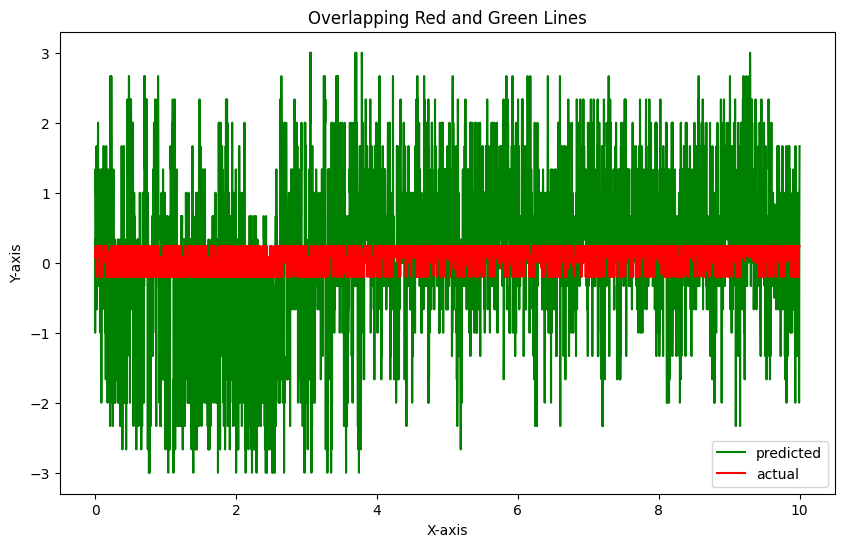

In [36]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

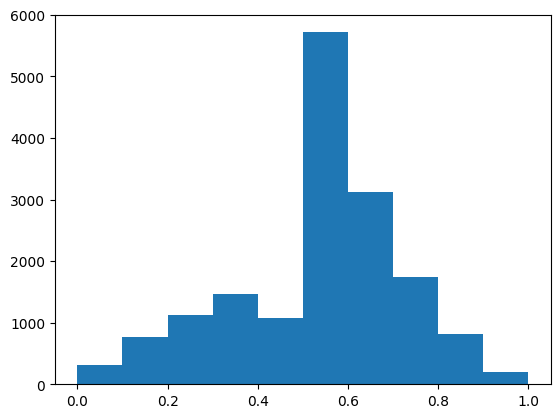

In [37]:
plt.hist(modelTrainData['Label'])

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([-3.        , -2.4000001 , -1.79999995, -1.20000005, -0.60000002,
         0.        ,  0.60000002,  1.20000005,  1.79999995,  2.4000001 ,
         3.        ]),
 <BarContainer object of 10 artists>)

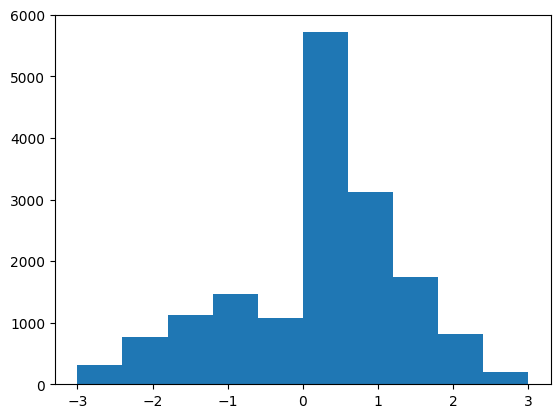

In [38]:
plt.hist(modelTrainData['Label_denorm'])

In [65]:
modelTrainData['Label_denorm']

array([[1.       ],
       [0.6666667],
       [0.       ],
       ...,
       [0.6666667],
       [1.       ],
       [1.       ]], dtype=float32)

In [61]:
sqrtDt = [arr[0]**(1/2) for arr in modelTrainData['Label_denorm']]

(array([3540.,    0.,    8., 2160., 1776., 1344., 1004.,  739.,  810.,
         207.]),
 array([0.        , 0.17320508, 0.34641016, 0.51961524, 0.69282032,
        0.8660254 , 1.03923048, 1.21243557, 1.38564065, 1.55884573,
        1.73205081]),
 <BarContainer object of 10 artists>)

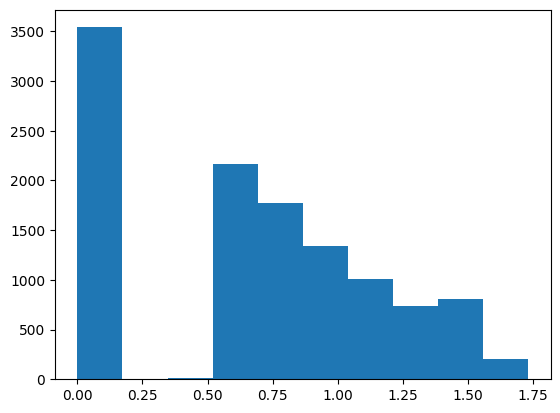

In [62]:

plt.hist(sqrtDt)

In [72]:
cubrtDt = [[np.log(arr[0])] for arr in modelTrainData['Label']]

/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_4225/1970934531.py:1: RuntimeWarning: divide by zero encountered in log
  cubrtDt = [[np.log(arr[0])] for arr in modelTrainData['Label']]


In [80]:
np.log(0)

/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_4225/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [74]:
modelTrainData['Label']

array([[0.6666667],
       [0.6111111],
       [0.5      ],
       ...,
       [0.6111111],
       [0.6666667],
       [0.6666667]], dtype=float32)

ValueError: supplied range of [-inf, 0.0] is not finite

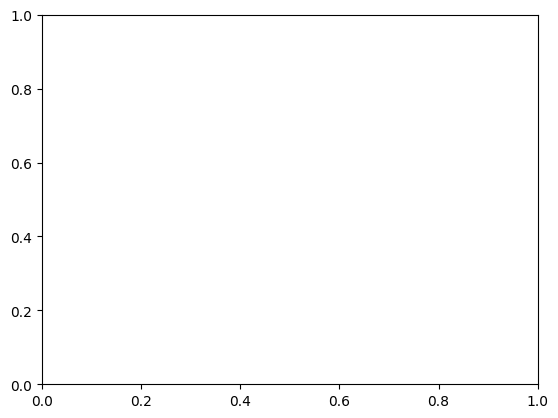

In [73]:
plt.hist(cubrtDt)

In [79]:

# Save the model to a directory
model.save('./savedModel1')

# Optionally, you can save the tokenizer used for encoding the text data
# tokenizer.save_pretrained('./savedModels')

INFO:tensorflow:Assets written to: ./savedModel1/assets


INFO:tensorflow:Assets written to: ./savedModel1/assets


In [ ]:
loaded_model = tf.keras.models.load_model('./savedModel1')
